In [1]:
from sklearn.cluster import KMeans
from multiprocessing import Pool
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import gc
from PIL import Image
import sys
sys.path.append("..")

In [2]:
from kuzushiji.utils.score import detection_f1, kuzushiji_f1
from kuzushiji.unet_model import MyUNet

In [3]:
IMG_SIZE = 600

In [4]:
def to_square(img, img_size=IMG_SIZE):
    three_d = len(img.shape) == 3
    if three_d:
        w, h, c = img.shape
    else:
        w, h = img.shape
        c = 1
    if w > h:
        h = int(h * img_size / w)
        w = img_size
    else:
        w = int(w * img_size / h)
        h = img_size
    img = cv2.resize(img, (h, w), interpolation=cv2.INTER_NEAREST).reshape([w, h, c])
    margin_w = (img_size - w) // 2
    margin_h = (img_size - h) // 2
    new_img = np.zeros((img_size, img_size, c))
    new_img[margin_w: margin_w + w, margin_h: margin_h + h, :] = img
    if not three_d:
        new_img = new_img.reshape([img_size, img_size])
    return new_img.astype('float32')

def coords_to_square(coords, shape):
    new = []
    w, h = shape[:2]
    for x, y in coords:
        if h > w:
            y = int(np.round(y * IMG_SIZE / h))
            x = x + (h - w) / 2
            x = int(np.round(x * IMG_SIZE / h))
        else:
            x = int(np.round(x * IMG_SIZE / w))
            y = y + (w - h) / 2
            y = int(np.round(y * IMG_SIZE / w))
        new.append([x, y])
    return np.array(new)

def unsquare(img, width, height, coords=None):
    if coords is None:
        if width > height:
            w = IMG_SIZE
            h = int(height * IMG_SIZE / width)
        else:
            h = IMG_SIZE
            w = int(width * IMG_SIZE / height)
        margin_w = (IMG_SIZE - w) // 2
        margin_h = (IMG_SIZE - h) // 2
        img = img[margin_w: margin_w + w, margin_h: margin_h + h]
        img = cv2.resize(img, (height, width))
    else:
        [x1, y1], [x2, y2] = coords
        [sx1, sy1], [sx2, sy2] = coords_to_square(coords, [width, height])
        img = cv2.resize(img[sx1: sx2, sy1: sy2], (y2 - y1, x2 - x1))
    return img

def get_centers(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    centers = []
    for cnt in contours:
        M = cv2.moments(cnt)
        if M['m00'] > 0:
            cy = M['m10'] / M['m00']
            cx = M['m01'] / M['m00']
        else:
            cy, cx = cnt[0][0]
        cx = int(np.round(cx))
        cy = int(np.round(cy))
        centers.append([cx, cy])
    centers = np.array(centers)
    return centers

def get_labels(centers, shape):
    if len(centers) == 0:
        return
    kmeans = KMeans(len(centers), init=centers)
    kmeans.fit(centers)
    coords = []
    mlt = 2
    for i in range(0, shape[0], mlt):
        coords.append([])
        for j in range(0, shape[1], mlt):
            coords[-1].append([i, j])
    coords = np.array(coords).reshape([-1, 2])
    preds = kmeans.predict(coords)
    preds = preds.reshape([shape[0] // mlt, shape[1] // mlt])
    labels = np.zeros(shape, dtype='int')
    for k in range(mlt):
        labels[k::mlt, k::mlt] = preds
    return labels

def get_voronoi(centers, mask):
    labels = get_labels(centers, mask.shape)
    colors = np.random.uniform(0, 1, size=[len(centers), 3])
    voronoi = colors[labels]
    voronoi *= mask[:, :, None]
    return voronoi

def get_rectangles(centers, mask):
    mask_sq = to_square(mask)
    centers_sq = coords_to_square(centers, mask.shape)
    labels_sq = get_labels(centers_sq, mask_sq.shape)
    rects = [None for _ in centers]
    valid_centers = []
    for i, (xc, yc) in enumerate(centers):
        msk = (labels_sq == i).astype('float') * mask_sq / mask_sq.max()
        # crop msk
        max_size = IMG_SIZE
        x1 = max(0, int(np.round(xc - max_size // 2)))
        y1 = max(0, int(np.round(yc - max_size // 2)))
        x2 = min(mask.shape[0], int(np.round(xc + max_size // 2)))
        y2 = min(mask.shape[1], int(np.round(yc + max_size // 2)))
        msk = unsquare(msk, mask.shape[0], mask.shape[1], coords=[[x1,y1], [x2, y2]])
        msk = cv2.inRange(msk, 0.5, 10000)
        contours, _ = cv2.findContours(msk, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        for cnt in contours:
            y, x, h, w = cv2.boundingRect(cnt)
            x += x1
            y += y1
            if xc >= x and xc <= x + w and yc >= y and yc <= y + h:
                rects[i] = [x, y, w, h]
                if cv2.contourArea(cnt) <= h * w * 0.66:
                    rad_x = min(xc - x, x + w - xc)
                    rad_y = min(yc - y, y + h - yc)
                    rects[i] = [int(np.round(xc - rad_x)), y, int(np.round(2 * rad_x)), h]
                break
        if rects[i] is not None:
            valid_centers.append([xc, yc])
    return np.array([r for r in rects if r is not None]), np.array(valid_centers)

def draw_rectangles(img, rects, centers, fill_rect=[1, 0, 0], fill_cent=[1, 0, 0], fill_all=False):
    new = np.array(img)
    for x, y, w, h in rects:
        for shift in range(4):
            try:
                if fill_all:
                    new[x: x + w, y: y + h] = fill_rect
                else:
                    new[x: x + w, y + shift] = fill_rect
                    new[x: x + w, y + h - shift] = fill_rect
                    new[x + shift, y: y + h] = fill_rect
                    new[x + w - shift, y: y + h] = fill_rect
            except:
                pass
    for x, y in centers:
        r = 15
        new[x - r: x + r, y - r: y + r] = fill_cent
    return new

def add_skipped(mask, boxes, centers):
    avg_w = np.mean([b[2] for b in boxes])
    avg_area = np.mean([b[2] * b[3] for b in boxes])
    new_centers, new_boxes = [], []
    mask_c = draw_rectangles(mask, boxes, [], 0, fill_all=True)
    contours, _ = cv2.findContours(mask_c, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    for cnt in contours:
        y, x, h, w = cv2.boundingRect(cnt)
        found = False
        for xc, yc in centers:
            if xc >= x and xc <= x + w and yc >= y and yc <= y + h:
                found = True
                break
        if not found and (w * h > avg_area * 0.66 or w > avg_w * 1.5):
            new_centers.append([x + w // 2, y + h // 2])
            new_boxes.append([x, y, w, h])
    if len(new_centers) > 0:
        boxes = np.concatenate([boxes, new_boxes], 0)
        centers = np.concatenate([centers, new_centers], 0)
    return boxes, centers

In [5]:
def check_iou_score(true_boxes,detected_boxes,iou_thresh):
    iou_all=[]
    for detected_box in detected_boxes:
        y1=np.maximum(detected_box[0],true_boxes[:,0])
        x1=np.maximum(detected_box[1],true_boxes[:,1])
        y2=np.minimum(detected_box[2],true_boxes[:,2])
        x2=np.minimum(detected_box[3],true_boxes[:,3])

        cross_section=np.maximum(0,y2-y1)*np.maximum(0,x2-x1)
        all_area=(detected_box[2]-detected_box[0])*(detected_box[3]-detected_box[1])+(true_boxes[:,2]-true_boxes[:,0])*(true_boxes[:,3]-true_boxes[:,1])
        iou=np.max(cross_section/(all_area-cross_section))
        #argmax=np.argmax(cross_section/(all_area-cross_section))
        iou_all.append(iou)
    score=2*np.sum(iou_all)/(len(detected_boxes)+len(true_boxes))
    print("score:{}".format(np.round(score,3)))
    return score

In [6]:
from albumentations import Resize, PadIfNeeded, Compose

In [7]:
def resize_image():
    return Compose([
        Resize(height=IMG_SIZE, width=IMG_SIZE, always_apply=True)
    ], p=1)

In [8]:
valid_transform = resize_image()

In [9]:
def process_labels(zipped):
    chars, centers, boxes = zipped
    if chars is None or centers is None or boxes is None:
        return "", ""
    label_centers = np.concatenate((chars, centers), axis=1)
    label_centers = label_centers.flatten()
    label_boxes = np.concatenate((chars, boxes), axis=1)
    label_boxes = label_boxes.flatten()
    return " ".join(label_centers), " ".join(label_boxes)

In [10]:
def classify_char(dataframe, boxes_df, image_location):
    image_indices = []
    pred_centers = []
    pred_boxes = []
    pred_chars = []
    for i in tqdm(range(dataframe.shape[0])):
        image_id = dataframe.iloc[i]["image_id"]
        image_indices.append(image_id)
        if boxes_df.iloc[i]['labels'] is None or boxes_df.iloc[i]['labels'] is np.nan:
            pred_centers.append(None)
            pred_boxes.append(None)
            pred_chars.append(None)
            continue
        labels = boxes_df.iloc[i]["labels"].split(" ")
        boxes = []
        for j in range(0, len(labels), 5):
            x = int(labels[j+1])
            y = int(labels[j+2])
            w = int(labels[j+3])
            h = int(labels[j+4])
            boxes.append((x, y, w, h))
        image = Image.open(image_location.format(image_id))
        chars, centers, boxes = classify(image, boxes)
        pred_chars.append(chars)
        pred_centers.append(centers)
        pred_boxes.append(boxes)
    
    p = Pool(processes=8)
    centers_boxes = p.map(process_labels, zip(pred_chars, pred_centers, pred_boxes))
    centers_boxes = np.array(centers_boxes)
        
    center_result = pd.DataFrame({'image_id': image_indices, 'labels': centers_boxes[:, 0]})
    box_result = pd.DataFrame({'image_id': image_indices, 'labels': centers_boxes[:, 1]})
    return center_result, box_result

In [11]:
def check_iou_score(true_boxes,detected_boxes):
    iou_all=[]
    for detected_box in detected_boxes:
        y1=np.maximum(detected_box[0],true_boxes[:,0])
        x1=np.maximum(detected_box[1],true_boxes[:,1])
        y2=np.minimum(detected_box[2],true_boxes[:,2])
        x2=np.minimum(detected_box[3],true_boxes[:,3])

        cross_section=np.maximum(0,y2-y1)*np.maximum(0,x2-x1)
        all_area=(detected_box[2]-detected_box[0])*(detected_box[3]-detected_box[1])+(true_boxes[:,2]-true_boxes[:,0])*(true_boxes[:,3]-true_boxes[:,1])
        iou=np.max(cross_section/(all_area-cross_section))
        #argmax=np.argmax(cross_section/(all_area-cross_section))
        iou_all.append(iou)
    score=2*np.sum(iou_all)/(len(detected_boxes)+len(true_boxes))
    return score

In [12]:
xy_train = pd.read_csv("../cache/xy_train.csv")
xy_dev = pd.read_csv("../cache/xy_dev.csv")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
model = MyUNet(n_classes=2)
model = model.to(device)
model.load_state_dict(torch.load("../checkpoints/unet_final2.pth"))
model.eval()
print('load model done')

load model done


In [14]:
def get_mask(img, labels):
    mask = np.zeros((img.shape[0], img.shape[1], 2), dtype='float32')
    if isinstance(labels, str):
        labels = np.array(labels.split(' ')).reshape(-1, 5)
        for char, x, y, w, h in labels:
            x, y, w, h = int(x), int(y), int(w), int(h)
            if x + w >= img.shape[1] or y + h >= img.shape[0]:
                continue
            mask[y: y + h, x: x + w, 0] = 1
            radius = 6
            mask[y + h // 2 - radius: y + h // 2 + radius + 1, x + w // 2 - radius: x + w // 2 + radius + 1, 1] = 1
    return mask

In [15]:
class PapirusDataset(Dataset):
    """Papirus dataset."""

    def __init__(self, dataframe, root_dir, transform, train=True):
        self.df = dataframe
        self.root_dir = root_dir
        self.train = train
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        idx, labels = self.df.values[idx]
        img_path = self.root_dir.format(idx)
        
        image = cv2.imread(img_path)
        shape = np.array(image.shape)[:2]
        if self.train:
            mask = get_mask(image, labels)
            padding = np.ones((shape[0], shape[1], 1), dtype=np.float32)
            mask = np.concatenate((mask, padding), axis=2)
        else:
            # fake mask
            mask = np.ones((shape[0], shape[1], 3), dtype=np.float32)
        data = {"image": image, "mask": mask}
        augmented = self.transform(**data)
        image, mask = augmented["image"], augmented["mask"]
        mask = mask[:,:,0:2]

        image = transforms.functional.to_tensor(image)
        mask = transforms.functional.to_tensor(mask)
        shape = torch.from_numpy(shape)
        sample = [image, mask, shape]
        return sample

## Validation data

In [16]:
def unsquare_image(image_height, image_width):
    return Compose([
        Resize(height=image_height, width=image_width, always_apply=True)
    ], p=1)

In [17]:
def detect_char(dataframe, dataloader):
    pred_boxes = []
    pred_centers = []

    for inputs, _, shape in tqdm(dataloader):
        with torch.no_grad():
            inputs = inputs.to(device)
            outputs = model(inputs)
        shape = np.array(shape)
        images = inputs.data.cpu().numpy()
        masks = outputs.data.cpu().numpy()
        for i in range(shape.shape[0]):
            image_shape = shape[i]
            image = images[i]
            image = np.moveaxis(image, 0, 2)
            mask = masks[i]
            mask = np.moveaxis(mask, 0, 2)
            padding = np.ones((mask.shape[0], mask.shape[1], 1), dtype=np.float32)
            mask = np.concatenate((mask, padding), axis=2)

            unsquare_transform = unsquare_image(image_shape[0], image_shape[1])
            data = {"image": image, "mask": mask}
            augmented = unsquare_transform(**data)
            image, mask = augmented["image"], augmented["mask"]
            mask = mask[:,:,0:2]
            
            binary0 = cv2.inRange(mask[:,:,0], 0.0, 10000)
            binary1 = cv2.inRange(mask[:,:,1], 0.0, 10000)    
            centers0 = get_centers(binary1)
            rects, centers = get_rectangles(centers0, binary0)
            rects, centers = add_skipped(binary0, rects, centers)

            cnts = []
            for x, y in centers:
                cnts += ['unk', str(y), str(x)]
            cnts = None if len(cnts) == 0 else ' '.join(cnts)
            pred_centers.append(cnts)

            boxes = []
            for x, y, w, h in rects:
                boxes += ['unk', str(y), str(x), str(h), str(w)]
            boxes = None if len(boxes) == 0 else ' '.join(boxes)
            pred_boxes.append(boxes)

    predictions_center = pd.DataFrame({'image_id': dataframe['image_id'], 'labels': pred_centers})
    predictions_box = pd.DataFrame({'image_id': dataframe['image_id'], 'labels': pred_boxes})

    return predictions_center, predictions_box

In [18]:
# for inputs, _, shape in dataloader:
#     with torch.no_grad():
#         inputs = inputs.to(device)
#         outputs = model(inputs)
#     shape = np.array(shape)
#     images = inputs.data.cpu().numpy()
#     masks = outputs.data.cpu().numpy()
#     for i in range(shape.shape[0]):
#         image_shape = shape[i]
#         image = images[i]
#         image = np.moveaxis(image, 0, 2)
#         mask = masks[i]
#         mask = np.moveaxis(mask, 0, 2)
#         padding = np.ones((mask.shape[0], mask.shape[1], 1), dtype=np.float32)
#         mask = np.concatenate((mask, padding), axis=2)

#         unsquare_transform = unsquare_image(image_shape[0], image_shape[1])
#         data = {"image": image, "mask": mask}
#         augmented = unsquare_transform(**data)
#         image, mask = augmented["image"], augmented["mask"]
#         mask = mask[:,:,0:2]

#         print(image.shape)
#         print(mask.shape)
#         print(image_shape)
        
#         binary0 = cv2.inRange(mask[:,:,0], 0.0, 10000)
#         binary1 = cv2.inRange(mask[:,:,1], 0.0, 10000)        
#         centers0 = get_centers(binary1)
#         rects, centers = get_rectangles(centers0, binary0)
#         rects, centers = add_skipped(binary0, rects, centers)
        
#         cnts = []
#         for x, y in centers:
#             cnts += ['unk', str(y), str(x)]
#         cnts = None if len(cnts) == 0 else ' '.join(cnts)
#         # pred_centers.append(cnts)
#         print(cnts)

#         boxes = []
#         for x, y, w, h in rects:
#             boxes += ['unk', str(y), str(x), str(h), str(w)]
#         boxes = None if len(boxes) == 0 else ' '.join(boxes)
#         # pred_boxes.append(boxes)
#         print(boxes)
        
#         break
#     break

In [19]:
image_loc = '../input/train_images/{}.jpg'

dataloader = DataLoader(PapirusDataset(xy_dev, image_loc, train=False, transform=valid_transform),
                        batch_size=1,
                        shuffle=False,
                        num_workers=8)

In [20]:
import warnings
warnings.filterwarnings("ignore")

In [21]:
# torch.cuda.empty_cache()
# gc.collect()

# valid_centers, valid_boxes = detect_char(xy_dev, dataloader)
# valid_centers.to_csv('../cache/valid_centers.csv', index=False)
# valid_boxes.to_csv('../cache/valid_boxes.csv', index=False)

In [22]:
valid_centers = pd.read_csv('../cache/valid_centers.csv')
valid_boxes = pd.read_csv('../cache/valid_boxes.csv')

detection_f1(valid_centers, xy_dev)

precision: 0.9690833072612987 recall: 0.9820435221213432


0.9755203710596387

In [23]:
image_id = valid_boxes.loc[1]["image_id"]
detected_labels = valid_boxes.loc[1]["labels"]
true_labels = xy_dev[xy_dev["image_id"] == image_id]["labels"].values[0]

In [24]:
def get_boxes(labels):
    boxes = np.array(labels.split(" ")).reshape(-1, 5)
    boxes = boxes[:, 1:5]
    boxes = boxes.astype(np.float)
    
    new_boxes = []
    for minx, miny, width, height in boxes:
        new_boxes.append([minx, miny, minx+width, miny+height])
    return np.array(new_boxes)

In [25]:
true_boxes = get_boxes(true_labels)
print(true_boxes.shape)

detected_boxes = get_boxes(detected_labels)
print(detected_boxes.shape)

(373, 4)
(360, 4)


In [26]:
image_path = "../input/train_images/{}.jpg".format(image_id)
img = cv2.imread(image_path)

In [27]:
for minx, miny, maxx, maxy in true_boxes.astype(np.int):
    img = cv2.rectangle(img, (minx, miny), (maxx, maxy), (0,255,0), 2)

for minx, miny, maxx, maxy in detected_boxes.astype(np.int):
    img = cv2.rectangle(img, (minx, miny), (maxx, maxy), (255,0,0), 2)

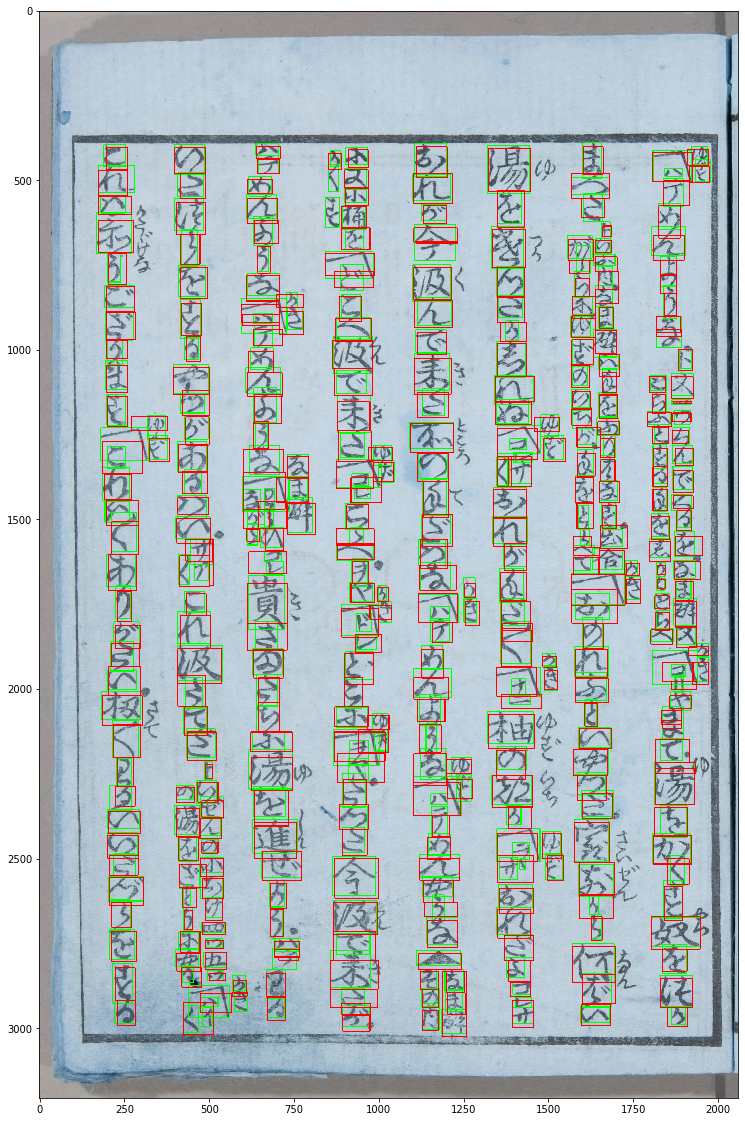

In [28]:
plt.figure(figsize=(20, 20))
plt.imshow(img)

In [29]:
iou_score = check_iou_score(true_boxes, detected_boxes)
print("score:{}".format(np.round(iou_score,3)))

score:0.645


In [30]:
torch.cuda.empty_cache()
gc.collect()

15

In [31]:
from kuzushiji.classify_character import classify

In [32]:
valid_label_centers, valid_label_boxes = classify_char(xy_dev, valid_boxes, image_loc)
valid_label_centers.to_csv('../cache/valid_label_centers.csv', index=False)
valid_label_boxes.to_csv('../cache/valid_label_boxes.csv', index=False)

In [33]:
valid_label_centers = pd.read_csv('../cache/valid_label_centers.csv')

kuzushiji_f1(valid_label_centers, xy_dev)

precision: 0.8453508271534512 recall: 0.8542441273958784


0.8497742097340691

In [34]:
torch.cuda.empty_cache()
gc.collect()

3

## Train data

In [35]:
df_train = pd.read_csv('../input/train.csv')
image_loc = '../input/train_images/{}.jpg'

dataloader = DataLoader(PapirusDataset(df_train, image_loc, train=False, transform=valid_transform),
                        batch_size=1,
                        shuffle=False,
                        num_workers=8)

In [36]:
train_centers, train_boxes = detect_char(df_train, dataloader)
train_centers.to_csv('../cache/train_centers.csv', index=False)
train_boxes.to_csv('../cache/train_boxes.csv', index=False)

In [37]:
train_centers = pd.read_csv('../cache/train_centers.csv')
train_boxes = pd.read_csv('../cache/train_boxes.csv')

detection_f1(train_centers, df_train)

precision: 0.96966330763986 recall: 0.9821482916437442


0.9758658688345371

In [38]:
torch.cuda.empty_cache()
gc.collect()

3

In [42]:
train_label_centers, train_label_boxes = classify_char(df_train, train_boxes, image_loc)
train_label_centers.to_csv('../cache/train_label_centers.csv', index=False)
train_label_boxes.to_csv('../cache/train_label_boxes.csv', index=False)

In [43]:
train_label_centers = pd.read_csv('../cache/train_label_centers.csv')

kuzushiji_f1(train_label_centers, df_train)

precision: 0.8445692422518677 recall: 0.8526520782367469


0.8485914134210528

In [44]:
torch.cuda.empty_cache()
gc.collect()

3

## Test data

In [45]:
image_loc = '../input/test_images/{}.jpg'
submission_df = pd.read_csv('../input/sample_submission.csv')

In [47]:
dataloader = DataLoader(PapirusDataset(submission_df, image_loc, train=False, transform=valid_transform),
                        batch_size=1,
                        shuffle=False,
                        num_workers=8)

sub_centers, sub_boxes = detect_char(submission_df, dataloader)
sub_centers.to_csv('../cache/sub_centers.csv', index=False)
sub_boxes.to_csv('../cache/sub_boxes.csv', index=False)

In [48]:
torch.cuda.empty_cache()
gc.collect()

3

In [49]:
sub_centers = pd.read_csv('../cache/sub_centers.csv')
sub_boxes = pd.read_csv('../cache/sub_boxes.csv')

In [51]:
sub_label_centers, sub_label_boxes = classify_char(submission_df, sub_boxes, image_loc)
sub_label_centers.to_csv('../cache/submission_center_8.csv', index=False)
sub_label_boxes.to_csv('../cache/submission_box_8.csv', index=False)